# Idempotent Generative Network
Implementation of the paper [Idempotent Generative Network](https://arxiv.org/abs/2311.01462).

## Import libraries

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Union, Optional
from torch.nn.common_types import _size_2_t

Set random seed for reproducibility

In [2]:
manual_seed = 1337
np.random.seed(manual_seed)
torch.manual_seed(manual_seed)

## IGN training routine
Based on "Source code 1" from the IGN paper.

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def train(f: nn.Module,
          f_copy: nn.Module,
          opt: torch.optim.Optimizer,
          data_loader: DataLoader,
          n_epochs: int,
          lambdas: tuple, # Weights for the different losses
          a: int # Clamp ratio for tight loss
          ):
  for epoch in range(n_epochs):
    losses = []
    iter = tqdm(data_loader, desc="Epoch {}".format(epoch + 1))
    for x, _ in iter:
      z = torch.randn_like(x).to(device)
      x = x.to(device)

      # apply f to get all needed
      f_copy.load_state_dict(f.state_dict())
      fx = f(x)
      fz = f(z)
      f_z = fz.detach()
      ff_z = f(f_z)
      f_fz = f_copy(fz)

      # calculate losses
      loss_rec = (fx - x).pow(2).mean()
      loss_idem = (f_fz - fz).pow(2).mean()
      loss_tight = -(ff_z - f_z).pow(2).mean()

      # smooth the tight loss
      smooth_tight_loss = nn.functional.tanh(loss_tight / (a * loss_rec)) * a * loss_rec

      # optimize for losses
      loss = lambdas[0] * loss_rec + lambdas[1] * loss_idem + lambdas[2] * smooth_tight_loss
      losses.append(loss.cpu().item())
      opt.zero_grad()
      loss.backward()
      opt.step()

      iter.set_postfix_str(f"Mean loss: {np.mean(losses)}")

    if epoch % 100 == 0:
      torch.save(f.state_dict() , "IGN_epoch_" + str(epoch) + ".pt")

## DCGAN Autoencoder
The paper explains the idempotent function $f$, to be an autoencoder. Specifically the discuss an architecture where the encoder is a simple five-layer discriminator backbone from [DCGAN](https://arxiv.org/abs/1511.06434), and the decoder is the generator. We implement this now.

From the DCGAN paper:
Architecture guidelines for stable Deep Convolutional GANs
* Replace any pooling layers with strided convolutions (discriminator) and fractional-strided
convolutions (generator).
* Use batchnorm in both the generator and the discriminator.
* Remove fully connected hidden layers for deeper architectures.
* Use ReLU activation in generator for all layers except for the output, which uses Tanh.
* Use LeakyReLU activation in the discriminator for all layers.

In [4]:
# Convolutional layer applying:
# Conv2D -> BatchNorm (optional) -> Non-linear activation (optional).
class Conv(nn.Module):
  def __init__(self,
               in_channels: int,
               out_channels: int,
               kernel_size: _size_2_t,
               stride: _size_2_t = 1,
               padding: Union[str, _size_2_t] = 0,
               batch_norm: bool = True,
               nonlinearity: str = 'relu',
               transposed: bool = False):
      super().__init__()
      self.conv = (nn.ConvTranspose2d if transposed else nn.Conv2d)(in_channels, out_channels, kernel_size, stride, padding)
      nn.init.normal_(self.conv.weight, .0, 0.02) # Papers suggests initializing weights from Normal(0.0, 0.02).
      nn.init.constant_(self.conv.bias.data, 0)
      #nn.init_normal_(self.bn.weight, .0, .02)
      #nn.init_constant_(self.bn.bias.data, 0)
      self.bn = nn.BatchNorm2d(out_channels, affine=False) if batch_norm else nn.Identity() # Authors suggest removing scale and bias parameter.
      match nonlinearity:
        case 'relu':
          self.nonlinearity = nn.ReLU(inplace=True) #Inplace can be faster/more memory efficient. But weird things can happen
        case 'leaky':
          self.nonlinearity = nn.LeakyReLU(.2, inplace=True) # As suggested in the DCGAN paper.
        case 'tanh':
          self.nonlinearity = nn.Tanh()
        case _:
          self.nonlinearity = nn.Identity()
      self.sequential = nn.Sequential(self.conv, self.bn, self.nonlinearity)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.sequential(x)

# Implemented as a DCGAN discriminator.
# Ignore applying Sigmoid at the end.
class Encoder(nn.Module):
  def __init__(self,
               in_channels: int = 3,
               nz=64,
               ngf=64):
    super().__init__()
    self.sequential = nn.Sequential(
      Conv(in_channels=in_channels, out_channels=64, kernel_size=4, stride=2, padding=1, batch_norm=False, nonlinearity='leaky', transposed=False),
      Conv(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, batch_norm=True, nonlinearity='leaky', transposed=False),
      Conv(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, batch_norm=True, nonlinearity='leaky', transposed=False),
      Conv(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, batch_norm=True, nonlinearity='leaky', transposed=False),
      Conv(in_channels=512, out_channels=512, kernel_size=4, stride=1, padding=0, batch_norm=False, nonlinearity=None, transposed=False))

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.sequential(x)

# Implemented as a DCGAN generator.
class Decoder(nn.Module):
  def __init__(self,
               out_channels: int = 3):
    super().__init__()
    self.sequential = nn.Sequential(
      Conv(in_channels=512, out_channels=512, kernel_size=4, stride=1, padding=0, batch_norm=True, nonlinearity='relu', transposed=True),
      Conv(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, batch_norm=True, nonlinearity='relu', transposed=True),
      Conv(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, batch_norm=True, nonlinearity='relu', transposed=True),
      Conv(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, batch_norm=True, nonlinearity='relu', transposed=True),
      Conv(in_channels=64, out_channels=out_channels, kernel_size=4, stride=2, padding=1, batch_norm=False, nonlinearity='tanh', transposed=True))

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.sequential(x)

# in_channels = 3, out channels = 3, for RGB image.
# in_channels = 1, out_channels = 1, for greyscale.
class AutoEncoder(nn.Module):
  def __init__(self,
               in_channels: int = 3,
               out_channels: int = 3):
    super().__init__()
    self.encoder = Encoder(in_channels)
    self.decoder = Decoder(out_channels)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.decoder(self.encoder(x))

## Load dataset

In [5]:
def load_data(dataset: Dataset, transform: any = None) -> tuple[any, any]:
  if transform is None:
    transform = transforms.ToTensor()
  training_data = dataset(
      root="data",
      train=True,
      download=True,
      transform=transform
  )
  test_data = dataset(
      root="data",
      train=False,
      download=True,
      transform=transform
  )
  return training_data, test_data

### Load MINST dataset

In [6]:
from torchvision.datasets import MNIST

transform = transforms.Compose([
          transforms.Resize(64), # To easier use suggested DCGAN Autoencoder architecture.
          transforms.ToTensor(),
          transforms.Normalize(
              mean=(.5,), std=(.5,) # Normalize values to range [-1,1],
          )
      ])
training_data, test_data = load_data(MNIST, transform)

In [7]:
def visualize_image(image: torch.Tensor):
  plt.imshow(image.squeeze(), cmap='gray')
  plt.show()

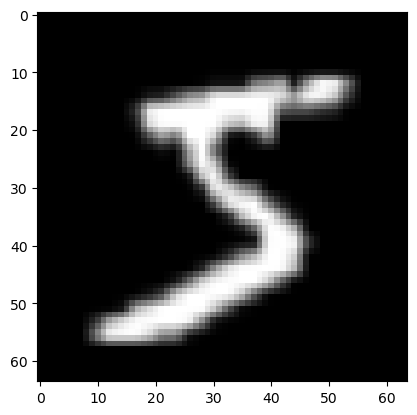

In [8]:
visualize_image(training_data[0][0])

## Instantiate model, optimizer and dataloader

In [9]:
# Hyperparameters:
batch_size = 128
lr = 1e-4
betas = .5, .999

# Taken from the paper
lambdas = 20, 20, 2.5
a = 1.5

n_epochs = 1000

f = AutoEncoder(in_channels=1, out_channels=1).to(device)
f_copy = AutoEncoder(in_channels=1, out_channels=1).requires_grad_(False).to(device) # Frozen copy, disable training.
opt = torch.optim.Adam(f.parameters(), lr=lr, betas=betas)
training_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

## Train the IGN

In [10]:
train(f, f_copy, opt, training_loader, n_epochs, lambdas, a)

Epoch 1000: 100%|██████████| 469/469 [00:37<00:00, 12.52it/s, Mean loss: 0.005976851065474342] 


In [11]:
# Save last model
torch.save(f.state_dict(), "IGN_epoch_" + str(n_epochs) + ".pt")

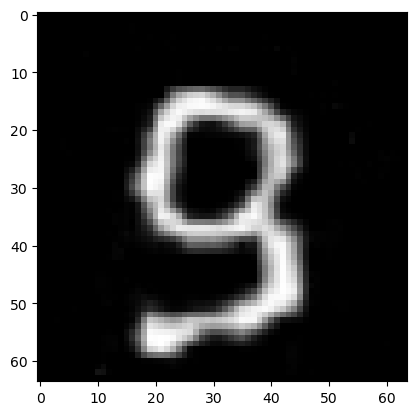

In [12]:
# Generate a sample

visualize_image(f(torch.randn((1, 1, 64, 64)).to(device)).detach().cpu())

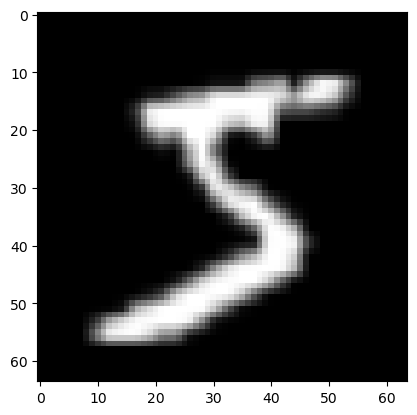

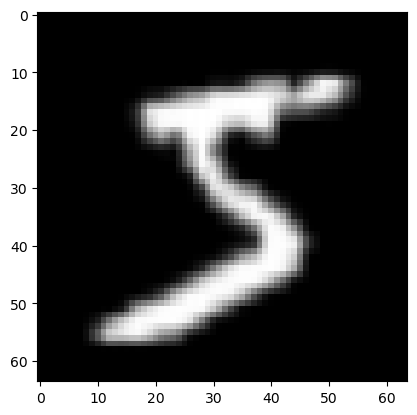

In [13]:
# Use a training sample
visualize_image(training_data[0][0])
visualize_image(f(training_data[0][0].to(device).unsqueeze(0)).detach().cpu())

In [15]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

def compare_imgs(img1, img2, i):
  # From Skimage SSIM documentation
  mse_none = mean_squared_error(img1, img1)
  mse_comp = mean_squared_error(img1, img2)

  ssim_none = ssim(img1, img1, data_range = max(img1.max(), img1.max()) - min(img1.min(), img1.min()))
  ssim_comp = ssim(img1, img2, data_range = max(img1.max(), img2.max()) - min(img1.min(), img2.min()))

  l2_comp = np.linalg.norm(img1 - img2)

  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharex=True, sharey=True)
  ax = axes.ravel()

  ax[0].imshow(img1, cmap=plt.cm.gray, vmin=0, vmax=1)
  ax[0].set_xlabel(f'MSE: {mse_none:.2f}, SSIM: {ssim_none:.2f}')
  ax[0].set_title('Original image')

  ax[1].imshow(img2, cmap=plt.cm.gray, vmin=0, vmax=1)
  ax[1].set_xlabel(f'MSE: {mse_comp:.2f}, SSIM: {ssim_comp:.2f}, L2: {l2_comp:.2f}')
  ax[1].set_title('Comparing image, i = ' + str(i))

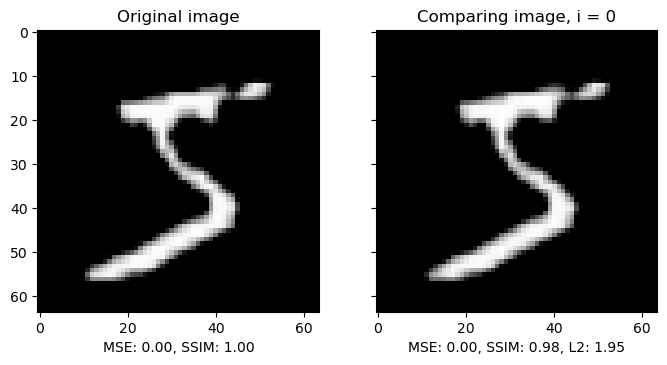

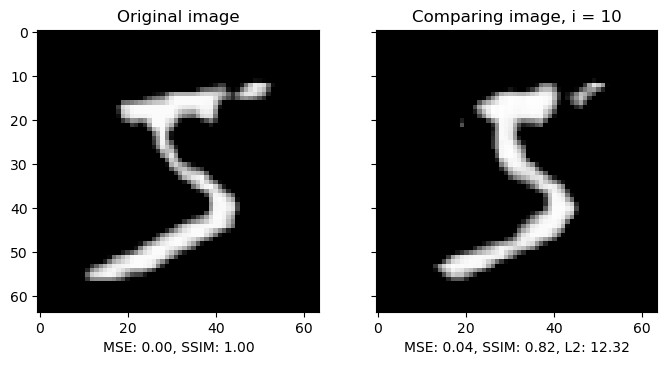

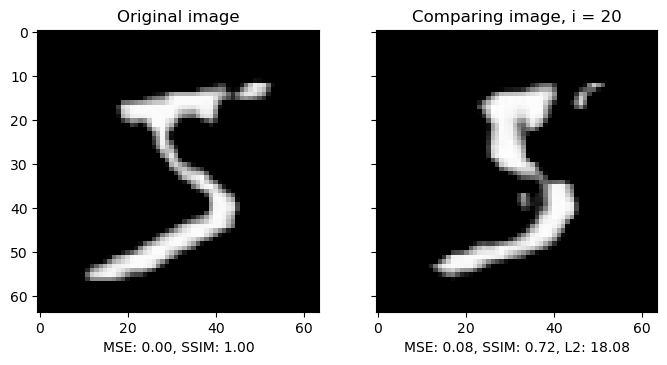

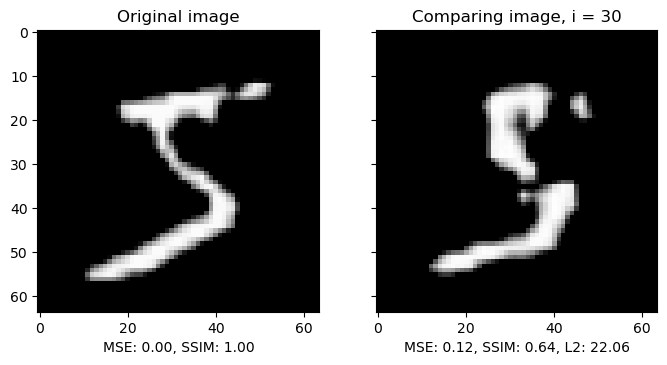

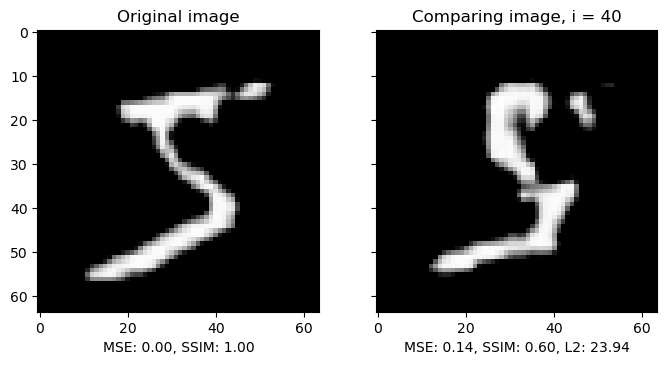

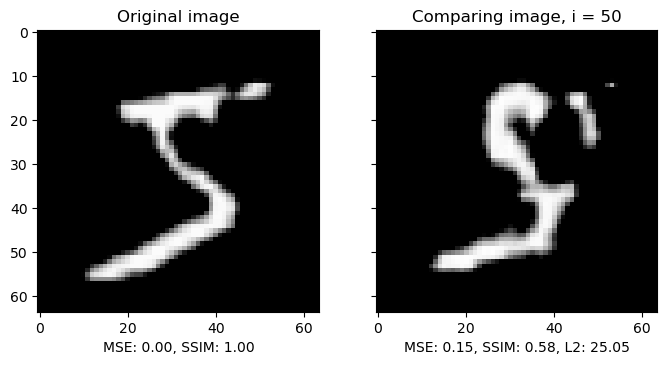

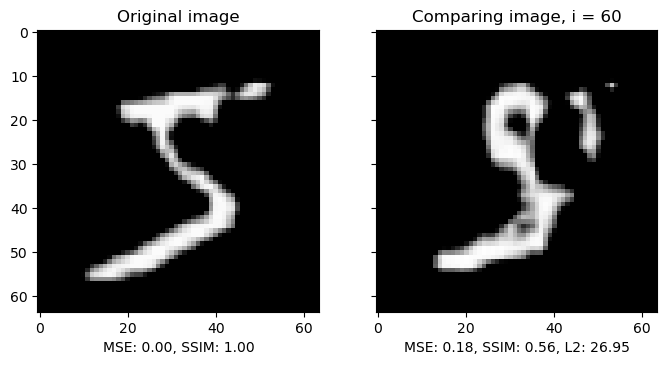

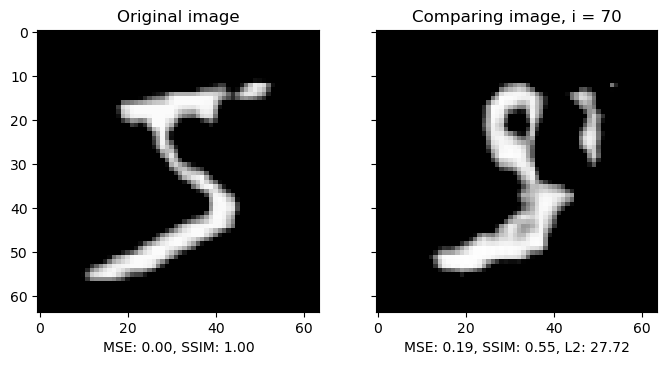

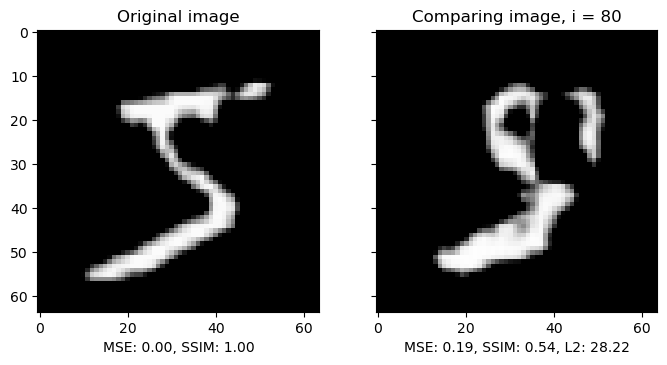

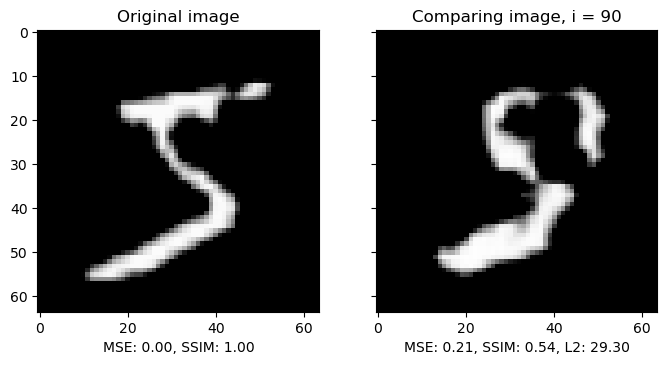

In [16]:
x_orig = training_data[0][0].numpy()[0]
x = training_data[0][0].to(device).unsqueeze(0)

for i in range(100):
  x = f(x).detach()

  if i % 10 == 0:
    compare_imgs(x_orig, x.cpu().numpy()[0, 0], i)

In [23]:
x_orig = training_data[0][0].numpy()[0]
x = training_data[0][0].to(device).unsqueeze(0)

n_its = 10000

mse_l = [None] * n_its
ssim_l = [None] * n_its
l2_l = [None] * n_its

def calc_metrics(img1, img2):
  mse_comp = mean_squared_error(img1, img2)
  ssim_comp = ssim(img1, img2, data_range = max(img1.max(), img2.max()) - min(img1.min(), img2.min()))
  l2_comp = np.linalg.norm(img1 - img2)

  return mse_comp, ssim_comp, l2_comp

for i in tqdm(range(n_its)):
  x = f(x).detach()
  mse_l[i], ssim_l[i], l2_l[i] = calc_metrics(x_orig, x.cpu().numpy()[0, 0])

100%|██████████| 10000/10000 [00:21<00:00, 457.03it/s]


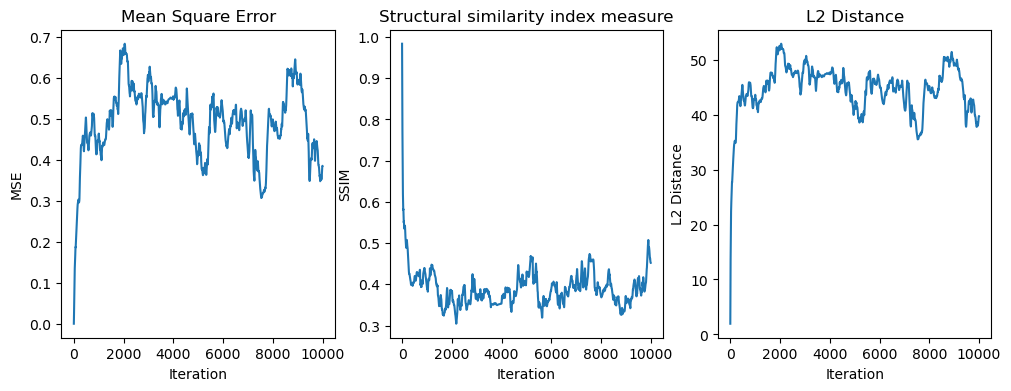

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
ax = axes.ravel()

ax[0].plot(mse_l)
ax[0].set_title('Mean Square Error')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('MSE')

ax[1].plot(ssim_l)
ax[1].set_title('Structural similarity index measure')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('SSIM')

ax[2].plot(l2_l)
ax[2].set_title('L2 Distance')
ax[2].set_xlabel('Iteration')
ax[2].set_ylabel('L2 Distance')

plt.show()